In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import sys
sys.path.append("..")
import ODE_Dynamics as od
import math
from random import sample

In [2]:
mu_b, sigma_b = 5, 1
beta = np.random.normal(mu_b, sigma_b, 1)
L = 0.0025/beta
V0 = np.random.normal(1E3, 1E2, 1)
X0 = 1E6
Y0 = V0
par=tf.constant(np.array([[L,0.01,beta*1E-7,0.5,20,10, V0, X0, Y0]], dtype=np.float32))
vpar = par
pospar = par
sympar = par

In [3]:
duration = 160

In [4]:
sample_size = 1000
k = 1
index = 1
mu_b, sigma_b = 5, 1
beta = np.random.normal(mu_b, sigma_b, 1)   #"rate at which virus infects host cells"
L = 0.0025/beta
par=np.array([[L,0.01,beta*1E-7,0.5,20.0,10.0]])
V0 = np.random.normal(1E3, 1E2, 1)
X0 = 1E6
Y0 = V0
init_state=(np.array([[V0,X0,Y0]], dtype=np.float32))

while index <= sample_size - 1:
    beta = np.random.normal(mu_b, sigma_b, 1)   #"rate at which virus infects host cells"
    L = 0.0025/beta
    par_new=np.array([[L,0.01,beta*1E-7,0.5,20.0,10.0]])
    par = np.concatenate((par, par_new), axis = 0)
    V0 = np.random.normal(1E3, 1E2, 1)
    X0 = 1E6
    Y0 = V0
    init_state_new=(np.array([[V0,X0,Y0]], dtype=np.float32))
    init_state = np.concatenate((init_state, init_state_new), 0)

    index +=1
        

vpar = tf.constant(par, dtype=tf.float32)
pospar = par
sympar = par
print(par.shape)



(1000, 6)


In [5]:
vm = od.ViralDynamics(vpar)
D_Vir = vm.Ndim
initial_state = vpar[...,-D_Vir:]
st1 = 0.0
vdyn_initial_time = st1
st2 = duration
vtimes = tf.constant(np.arange(st1, st2, step = 1, 
                                            dtype=np.float32))

DP = tfp.math.ode.DormandPrince()
results = DP.solve(vm.RHS, vdyn_initial_time, initial_state,
                           solution_times = vtimes)

vload = results.states[...,0]  
# But this has shape self.vtimes.shape[0] + vpar.shape[:-1].
# We want vpar.shape[:-1] + self.vtimes.shape[0]
r = len(vload.shape)
p = (np.arange(r) + 1) % r
vload = tf.transpose(vload, perm = p)

print(vload.shape)

(1000, 160)


In [6]:
# Return number tested, number of positives, new infections and true negative tests
n_tests = []; n_positives = []; 
n_new_infections = [] ; n_true_negatives = []; n_false_positives = [];

# Set population size and duration of the epidemic
pop_size = 10000
pop_id = [id for id in range(pop_size)]

# Set parameters for epidemic model
R0 = 1.8
mu = 5.0E-08
nu = 0.1
par=tf.constant(np.array([[R0, mu, nu]], dtype = np.float32))

# Find viral load threshold: 1E-05 of the maximum load
# Example 1: Threshold for COVID-19 RT-PCR test is 6.25 cp/μL. Maximum load about 625500
# Example 2: HIV load ranges about (1E4, 1E6). Threshold is 20 for RT-PCR
# v_threshold = 170306.4 * 1E-02

# New viral threshold: approx. typical viral load after 5 days of infection

v_threshold = 170306.4 * 1E-05
# 10000

# Set probability of exhibiting symptom (studies show about 0.55)
prob_s_i = 0.55
# Probability of symptoms and no infection
# Every year 9% of world population is infected by seasonal flu
prob_s_ibar = 0.1  
# 10% of all uninfected individuals are symptomatic
# False postive probability
prob_fp = 0


In [7]:
# Get epidemic model
mod = od.SIR(par)

# At the start of the epidemic most people are succeptible
init_state=tf.constant(np.array([[0.001,0.999]], dtype=np.float32))

# Generate time stamps for duration of epidemic
init_time=tf.constant(0)
num = int(duration)
soln_times=tf.constant(np.linspace(0, duration, num, dtype=np.int32))

# Get I, S, R values through duration of the epidemic
dp = tfp.math.ode.DormandPrince()
results = dp.solve(mod.RHS, init_time, init_state, solution_times=soln_times)
t = results.times
i = results.states[:,0,0] ; s = results.states[:,0,1] ; r = 1.0 - i - s;

# Before epidemic everybody is succeptible
I = []
S = pop_id
R = []

# Record id of individuals in I, S, R compartments at time = 0

time = 0
n_i = int(pop_size * i.numpy()[time])
n_s = int(pop_size * s.numpy()[time])
n_r = int(pop_size * r.numpy()[time])
    
I = sample(pop_id, n_i)
S = [id for id in S if id not in I]
R = []

#n_new_infections.append(len(I))

# Record time stamp of infection for each infected individual

I_T = [0] * len(I)

# Record people who tested positive

positives = []
    

while time < 10:
    time += 1
    # New births
    n_b = math.floor(mu * len(S))
    pop_size += n_b
    
    if n_b > 0:
        id_first = pop_size + 1
        id_last = id_first + n_b -1
        new_id = [id for id in range(id_first, id_last, 1)]
        S.append(new_id)
    
    # Removal by death
    s1 = math.floor(mu * len(S))
    if s1 > 0:
        S1 = sample(S, s1)
        S = [id for id in S if id not in S1]

    i1 = math.floor(mu * len(I))
    if i1 > 0:
        I1 = sample(I, i1)
        for id in I1:
            ind = I.index(id)
            print(ind, len(I_T), len(I))
            del I_T[ind]
            del I[ind]
        
    r1 = math.floor(mu * len(R))
    if r1 > 0:
        R1 = sample(R, r1)
        R = [id for id in R if id not in R1]

    pop_size = pop_size - s1 - i1 -r1
    
    n_i0 = int(pop_size * i.numpy()[time-1])
    n_s0 = int(pop_size * s.numpy()[time-1])
    n_r0 = pop_size - n_i0 - n_s0
    
    n_i = int(pop_size * i.numpy()[time])
    n_s = int(pop_size * s.numpy()[time])
    n_r = pop_size - n_i - n_s
    
    # New numbers of I, S, R at time
    dn_s = n_s0 - n_s; dn_r = n_r - n_r0
    
    #n_new_infections.append(dn_s)
    
    # Update I, S, R compartments
    if dn_s <= len(S):
        I0 = sample(S, dn_s)
        S = [id for id in S if id not in I0]
        I = I + I0
        I_T = I_T + [time] * len(I0)
    else:
        I = I + S
        S = []
    
    if dn_r <= len(I):
        R0 = sample(I, dn_r)
        for id in R0:
            ind = I.index(id)
            del I_T[ind]
            del I[ind]
        R = R + R0
    else:
        R = R + I
        I = []
        I_T = []
        break
    
    # Choose infected individuals who are symptomatic
    smp_i = []; I_T_smp = []
    for id in range(len(I)):
        if int(np.random.binomial(size = 1, n = 1, p = prob_s_i))== 1:
            smp_i.append(I[id])
            I_T_smp.append(I_T[id])

while time < duration-1:
    
    # New births
    n_b = math.floor(mu * len(S))
    pop_size += n_b
    
    if n_b > 0:
        id_first = pop_size + 1
        id_last = id_first + n_b -1
        new_id = [id for id in range(id_first, id_last, 1)]
        S.append(new_id)
    
    # Removal by death
    s1 = math.floor(mu * len(S))
    if s1 > 0:
        S1 = sample(S, s1)
        S = [id for id in S if id not in S1]

    i1 = math.floor(mu * len(I))
    if i1 > 0:
        I1 = sample(I, i1)
        for id in I1:
            ind = I.index(id)
            print(ind, len(I_T), len(I))
            del I_T[ind]
            del I[ind]
        
    r1 = math.floor(mu * len(R))
    if r1 > 0:
        R1 = sample(R, r1)
        R = [id for id in R if id not in R1]

    pop_size = pop_size - s1 - i1 -r1
    
    n_i0 = int(pop_size * i.numpy()[time-1])
    n_s0 = int(pop_size * s.numpy()[time-1])
    n_r0 = pop_size - n_i0 - n_s0
    
    n_i = int(pop_size * i.numpy()[time])
    n_s = int(pop_size * s.numpy()[time])
    n_r = pop_size - n_i - n_s
    
    # New numbers of I, S, R at time
    dn_s = n_s0 - n_s; dn_r = n_r - n_r0
    
    n_new_infections.append(dn_s)
    
    # Update I, S, R compartments
    if dn_s <= len(S):
        I0 = sample(S, dn_s)
        S = [id for id in S if id not in I0]
        I = I + I0
        I_T = I_T + [time] * len(I0)
    else:
        I = I + S
        S = []
    
    if dn_r <= len(I):
        R0 = sample(I, dn_r)
        for id in R0:
            ind = I.index(id)
            del I_T[ind]
            del I[ind]
        R = R + R0
    else:
        R = R + I
        I = []
        I_T = []
        break
    
    # Choose infected individuals who are symptomatic
    smp_i = []; I_T_smp = []
    for id in range(len(I)):
        if int(np.random.binomial(size = 1, n = 1, p = prob_s_i))== 1:
            smp_i.append(I[id])
            I_T_smp.append(I_T[id])
    
    # Choose healthy individuals who are symptomatic
    S_R = S + R
    smp_ibar = [id for id in S_R if int(np.random.binomial(size = 1, n = 1, p = prob_s_ibar))== 1]
    
    # All symptomatic individual
    smp = smp_i + smp_ibar
    T_smp = I_T_smp + [-1] * len(smp_ibar)
    
    # Only those individuals are tested who have never been tested positive
    tested = [id for id in smp if id not in positives]
    n_tests.append(len(tested))
    
    # Find viral load of infected individuals being tested
    
    # Determine which individuals are tested positive
    
    # Positives among infected
    pos1 = []
    
    # Find viral load of all infected individuals being tested
    smp_i_tested = [id for id in smp_i if id in tested]
    for id in range(len(smp_i_tested)):
        tau = int(time - I_T_smp[id])
        random_id = sample(range(sample_size), 1)[0]
        v_tau = vload[random_id, tau].numpy()
        if v_tau > v_threshold:
            pos1.append(id)
    
    # Positives among uninfected
    pos2 = [id for id in smp_ibar if int(np.random.binomial(1, prob_fp, 1)) == 1]
    n_true_negatives.append(len(tested) - len(smp_i_tested))
    n_false_positives.append(len(pos2))
    
    # All positive tests
    pos = pos1 + pos2
    n_positives.append(len(pos))
    
    # Update historical set of all positive individuals
    positives = positives + pos
    
    print(time)
    print(I_T_smp)
    
    time += 1
    

10
[0, 2, 3, 4, 4, 5, 5, 6, 8, 8, 9, 9, 10]
11
[0, 3, 4, 4, 6, 7, 8, 8, 10, 10, 10, 10, 11, 11, 11]
12
[0, 1, 2, 3, 4, 5, 7, 10, 10, 10, 10, 11, 11, 11, 12, 12]
13
[0, 1, 3, 5, 5, 6, 7, 8, 8, 10, 11, 11, 12, 13, 13, 13]
14
[0, 2, 3, 4, 4, 5, 6, 8, 10, 10, 10, 11, 12, 12, 12, 13, 14, 14]
15
[1, 4, 5, 10, 10, 10, 11, 12, 13, 14, 14, 14, 15, 15]
16
[0, 3, 5, 6, 8, 10, 11, 12, 12, 13, 13, 14, 14, 14, 15, 16, 16, 16, 16]
17
[0, 2, 8, 8, 10, 12, 13, 14, 15, 15, 15, 16, 16, 17, 17, 17, 17, 17]
18
[0, 4, 4, 5, 10, 12, 13, 13, 13, 14, 14, 14, 15, 15, 16, 16, 16, 17, 17, 18, 18]
19
[3, 4, 5, 5, 6, 8, 10, 10, 11, 13, 13, 14, 14, 14, 15, 16, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19]
20
[1, 5, 6, 8, 10, 11, 12, 13, 14, 14, 14, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18, 19, 20, 20, 20, 20]
21
[3, 6, 12, 13, 13, 16, 16, 17, 17, 17, 17, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 21, 21, 21, 21, 21, 21]
22
[6, 11, 13, 13, 15, 16, 17, 18, 18, 19, 19, 20, 20, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22]
23
[4

47
[19, 22, 25, 25, 25, 26, 29, 30, 30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47]
48
[19, 24, 25, 25, 25, 26, 27, 29, 29, 29, 30, 30, 30, 30, 31, 31, 32, 32, 33, 33, 33, 33, 33, 34, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 

57
[24, 29, 31, 31, 31, 32, 34, 35, 35, 35, 36, 36, 36, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 41, 41, 41, 42, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 

63
[25, 31, 34, 34, 35, 35, 35, 36, 36, 37, 38, 38, 38, 39, 39, 39, 39, 39, 39, 40, 40, 42, 42, 43, 44, 44, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 

69
[25, 25, 33, 35, 36, 36, 37, 37, 38, 39, 40, 40, 42, 42, 43, 43, 44, 45, 45, 46, 46, 46, 47, 47, 47, 47, 47, 48, 48, 48, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 

73
[31, 36, 37, 37, 39, 40, 42, 42, 43, 44, 45, 46, 47, 47, 48, 48, 48, 49, 49, 49, 50, 50, 50, 51, 51, 51, 51, 52, 52, 52, 52, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 

77
[25, 36, 36, 37, 39, 40, 42, 43, 43, 43, 44, 46, 47, 47, 47, 48, 48, 48, 48, 48, 49, 49, 50, 50, 51, 51, 51, 52, 52, 53, 53, 53, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 

81
[25, 36, 37, 40, 43, 44, 46, 46, 47, 48, 48, 49, 49, 49, 50, 50, 51, 51, 51, 52, 53, 53, 54, 55, 55, 55, 55, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 

85
[37, 40, 42, 43, 46, 47, 48, 49, 50, 51, 51, 51, 51, 52, 54, 55, 56, 56, 56, 56, 56, 57, 57, 58, 58, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 

89
[25, 40, 43, 44, 50, 51, 51, 53, 55, 55, 57, 57, 57, 58, 59, 59, 59, 59, 60, 60, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 

93
[42, 44, 48, 54, 55, 56, 57, 57, 57, 58, 59, 60, 61, 61, 62, 62, 62, 62, 63, 63, 63, 63, 63, 64, 64, 64, 64, 65, 65, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 

97
[43, 44, 46, 48, 49, 51, 55, 56, 56, 59, 59, 60, 60, 61, 62, 62, 63, 63, 63, 63, 64, 64, 66, 66, 66, 67, 67, 67, 67, 67, 67, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 

102
[43, 46, 51, 58, 58, 59, 61, 62, 63, 63, 64, 64, 64, 66, 66, 67, 67, 68, 69, 69, 70, 71, 71, 71, 71, 72, 72, 72, 72, 73, 73, 73, 73, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94,

107
[43, 46, 49, 51, 58, 58, 61, 62, 62, 63, 63, 63, 64, 66, 66, 68, 69, 69, 70, 71, 71, 72, 72, 72, 72, 74, 74, 75, 75, 75, 75, 76, 76, 76, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 79, 79, 80, 80, 80, 80, 80, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 87, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 

114
[51, 63, 64, 66, 69, 69, 70, 71, 72, 72, 72, 75, 77, 78, 79, 80, 80, 81, 82, 82, 82, 82, 83, 83, 83, 84, 85, 86, 86, 87, 87, 88, 88, 88, 89, 89, 89, 89, 89, 90, 90, 90, 91, 91, 91, 91, 91, 91, 92, 92, 92, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 95, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 111, 111, 111, 111, 111, 111, 111, 112,

122
[61, 69, 69, 72, 72, 72, 77, 77, 78, 80, 80, 81, 83, 84, 84, 85, 86, 87, 89, 89, 89, 90, 90, 90, 90, 91, 91, 91, 92, 92, 93, 97, 97, 97, 98, 98, 98, 98, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 102, 102, 102, 102, 102, 103, 103, 104, 104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 108, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110, 110, 110, 111, 111, 111, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114, 114, 114, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 116, 116, 116, 116, 116, 116, 116, 116, 116, 117, 117, 117, 118, 118, 118, 118, 118, 118, 118, 118, 119, 119, 119, 119, 120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122]
123
[58, 59, 61, 72, 72, 72, 75, 79, 80, 81, 81, 82, 85, 87, 88, 88, 89, 89, 90, 90, 90, 91, 91, 91, 91, 92, 92, 92, 93, 9

134
[51, 72, 75, 77, 77, 81, 87, 89, 91, 92, 94, 97, 99, 100, 100, 102, 104, 104, 104, 105, 107, 108, 108, 109, 109, 109, 110, 111, 111, 111, 112, 112, 113, 113, 115, 115, 116, 116, 116, 117, 117, 117, 118, 119, 119, 120, 120, 120, 121, 122, 122, 122, 123, 123, 123, 124, 124, 124, 125, 125, 125, 125, 126, 126, 127, 128, 129, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 131, 131, 131, 131, 131, 131, 132, 132, 132, 132, 133, 133, 133, 133, 133, 133, 134, 134, 134, 134, 134]
135
[51, 75, 77, 81, 84, 87, 91, 91, 92, 92, 94, 100, 100, 100, 101, 102, 104, 105, 106, 108, 108, 108, 108, 109, 109, 109, 110, 111, 111, 112, 112, 115, 115, 115, 115, 116, 116, 116, 117, 119, 120, 121, 122, 122, 122, 122, 123, 123, 124, 124, 124, 125, 125, 125, 125, 125, 125, 126, 126, 127, 127, 127, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 130, 130, 130, 131, 131, 131, 131, 131, 131, 131, 131, 132, 132, 132, 133, 133, 133, 134, 134, 134, 134, 135, 135, 135, 135, 135, 135, 135]
136
[51, 75, 87, 89, 91,

In [8]:
print(len(n_new_infections[11:(duration+1)]))

138


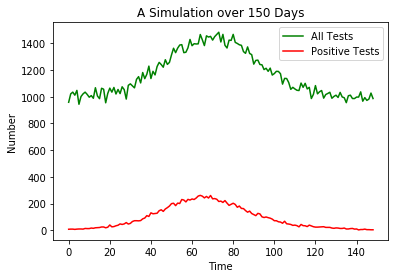

In [9]:
import matplotlib.pyplot as plt
t = list(range(len(n_tests)))
plt.plot(t, n_tests,"g-", t, n_positives, "r-")
plt.legend(['All Tests','Positive Tests'],loc = 'upper right')
plt.xlabel('Time')
plt.ylabel('Number')
plt.title("A Simulation over 150 Days")
plt.savefig('simulation_plot.png', dpi=300, bbox_inches='tight')

In [10]:
simulation_results = np.column_stack((n_tests, n_positives, n_new_infections, n_true_negatives, n_false_positives))
headings = ['Tests', 'Positives', 'New Infections', 'True Negatives', 'False Positives']
simulation_results = np.vstack([headings, simulation_results])
    
with open("simulation_data.txt", "w") as txt_file:
    for line in simulation_results:
        txt_file.write(" ".join(line) + "\n")
